In [1]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/proj_energy_volatility


In [2]:
from typing import List, Dict, Optional
from dotenv import load_dotenv
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from src.trading.IBKR_trading import TradingApp
import logging
# logging.getLogger('ib_insync').setLevel(logging.WARNING)
# optionally configure root logger if you haven't already
# logging.basicConfig(level=logging.WARNING)

In [3]:
plt.style.use("styler.mplstyle") 
load_dotenv()

True

In [4]:
HOST = os.getenv("IB_HOST")
PORT = int(os.getenv("IB_PORT"))
CLIENT_ID = int(os.getenv("IB_CLIENT_ID"))

app = TradingApp()
await app.start(HOST, PORT, clientid=CLIENT_ID)


Connected to Interactive Brokers successfully.


### Energy Sector and NYSE 

In [5]:

file_path = os.path.join(repo_root, 'data', 'nyse.csv')
tickers = pd.read_csv(file_path)

In [6]:
energy_sector = tickers[tickers['Sector'] == 'Energy'].sort_values(by=['Market Cap'], ascending=False)

In [7]:
energy_sector

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
2133,XOM,Exxon Mobil Corporation Common Stock,$117.22,2.720,2.376%,4.943362e+11,United States,NaN,17177678,Energy,Integrated oil Companies
521,CVX,Chevron Corporation Common Stock,$155.02,2.080,1.36%,3.145728e+11,United States,NaN,9835318,Energy,Integrated oil Companies
466,COP,ConocoPhillips Common Stock,$86.83,1.170,1.366%,1.084457e+11,United States,NaN,7567444,Energy,Integrated oil Companies
1273,MPC,Marathon Petroleum Corporation Common Stock,$193.76,1.040,0.54%,5.824474e+10,United States,NaN,2174154,Energy,Integrated oil Companies
677,EOG,EOG Resources Inc. Common Stock,$105.41,0.410,0.39%,5.755317e+10,United States,NaN,7052616,Energy,Oil & Gas Production
...,...,...,...,...,...,...,...,...,...,...,...
2040,VOC,VOC Energy Trust Units of Beneficial Interest,$2.885,0.035,1.228%,4.904500e+07,United States,2011.0,122590,Energy,Oil & Gas Production
1592,PRT,PermRock Royalty Trust Units of Beneficial Int...,$3.8901,0.009,0.232%,4.732591e+07,United States,2018.0,25601,Energy,Oil & Gas Production
491,CRT,Cross Timbers Royalty Trust Common Stock,$7.77,0.160,2.102%,4.662000e+07,United States,1992.0,19153,Energy,Oil & Gas Production
1371,NINE,Nine Energy Service Inc. Common Stock,$0.5001,0.000,0.00%,2.168501e+07,United States,2018.0,2064948,Energy,Oilfield Services/Equipment


In [8]:
market_contribution = tickers[tickers['Sector'] == 'Energy']['Market Cap'].sum() / tickers['Market Cap'].sum()
print(f"Market Contribution of Energy Stocks: {market_contribution :.2f} %")

Market Contribution of Energy Stocks: 0.05 %


In [9]:
top_5 = energy_sector['Symbol'].head(5).to_list()
print(f"Largest Market Cap Energy Companies: {top_5}")

Largest Market Cap Energy Companies: ['XOM', 'CVX', 'COP', 'MPC', 'EOG']


### Stock Information

In [10]:
def long_to_wide(df, pivot_by='close'):

    wide = df.pivot(index='date', columns='Symbol', values=pivot_by)
    wide = wide.reset_index()  
    wide.columns.name = None

    return wide


In [11]:
df = await app.fetch_one_symbol('EXE')

In [12]:
df

,date,Symbol,open,high,low,close,volume
0,2023-11-10,EXE,81.00,81.18,78.27,79.09,1319206.0
1,2023-11-13,EXE,80.17,80.85,79.33,80.01,688948.0
2,2023-11-14,EXE,80.15,81.87,80.00,81.54,515149.0
3,2023-11-15,EXE,81.21,83.71,80.98,83.25,948115.0
4,2023-11-16,EXE,82.41,83.16,80.35,81.13,1259977.0
...,...,...,...,...,...,...,...
494,2025-11-03,EXE,103.73,110.35,103.03,110.08,2262559.0
495,2025-11-04,EXE,109.46,111.77,108.14,110.05,1752188.0
496,2025-11-05,EXE,109.42,112.45,108.74,110.05,1346454.0
497,2025-11-06,EXE,110.61,112.63,109.10,110.62,1083207.0


In [13]:

df = await app.fetch_many_symbols(top_5, '2 Y', '1 day', 'TRADES', rth=True)

In [14]:
df

,date,Symbol,open,high,low,close,volume
0,2023-11-09,XOM,103.67,103.97,102.85,102.96,11668484.0
1,2023-11-10,XOM,103.93,104.41,102.90,103.75,11678414.0
2,2023-11-13,XOM,104.05,105.14,103.80,104.84,9519663.0
3,2023-11-14,XOM,104.30,104.82,103.87,104.29,12086807.0
4,2023-11-15,XOM,103.96,105.15,103.50,103.66,13073656.0
...,...,...,...,...,...,...,...
2500,2025-11-03,EOG,105.91,105.99,103.90,105.64,2159804.0
2501,2025-11-04,EOG,104.00,105.49,103.97,105.26,2396456.0
2502,2025-11-05,EOG,105.06,106.50,104.75,105.19,1992921.0
2503,2025-11-06,EOG,105.57,106.60,104.82,105.00,3185531.0


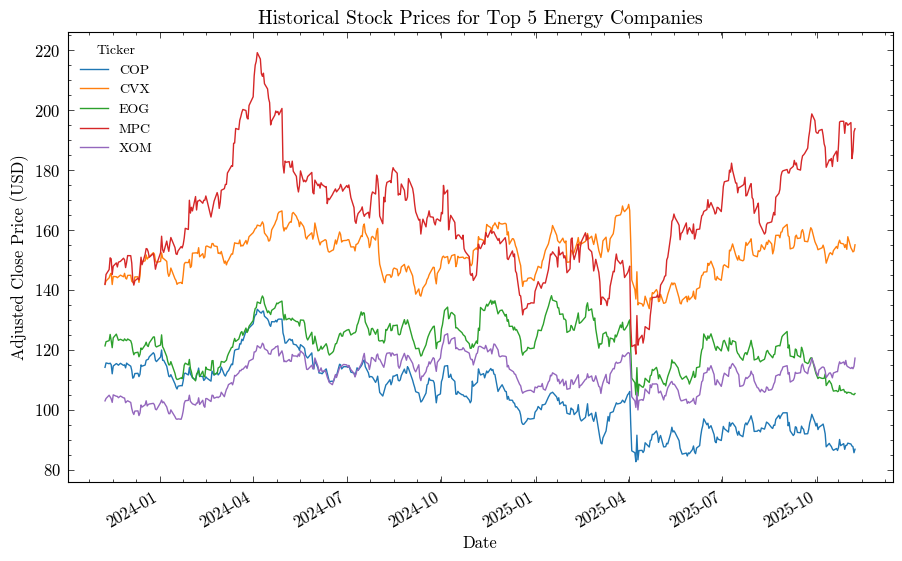

In [15]:

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")

for name, group in df.groupby('Symbol'):
    group.plot(x='date', y='close', ax=ax, label=name)

ax.set_title('Historical Stock Prices for Top 5 Energy Companies', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price (USD)')
ax.legend(title='Ticker')

plt.show()

In [16]:
index = ['XLE', 'SPY']

In [17]:

index_stock = await app.fetch_many_symbols(index, '2 Y', '1 day', 'TRADES', rth=True)
wide = long_to_wide(index_stock)

In [18]:
wide

,date,SPY,XLE
0,2023-11-09,433.84,82.50
1,2023-11-10,440.61,83.41
2,2023-11-13,440.19,84.01
3,2023-11-14,448.73,84.76
4,2023-11-15,449.68,84.60
...,...,...,...
496,2025-11-03,683.34,88.14
497,2025-11-04,675.24,87.19
498,2025-11-05,677.58,87.42
499,2025-11-06,670.31,88.27


Text(0, 0.5, 'Adjusted Close Price (USD)')

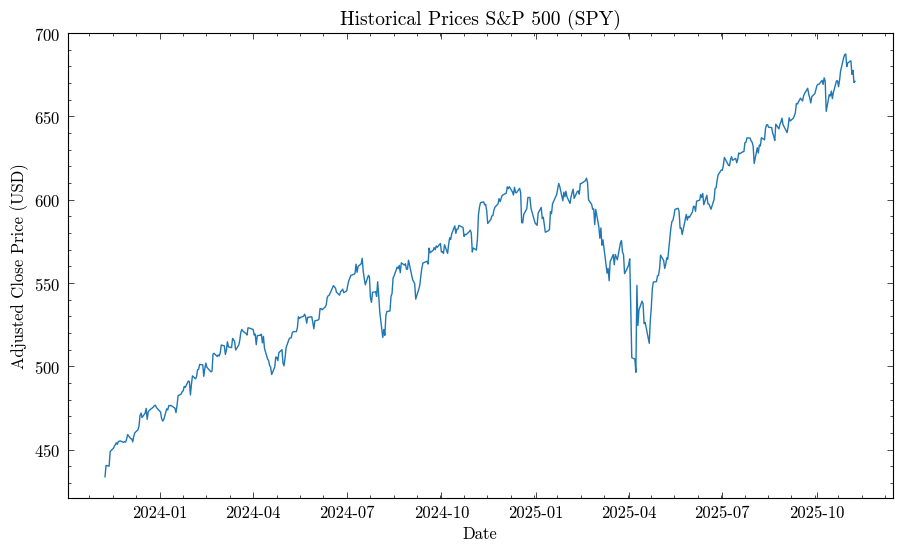

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")
ax.plot(wide['date'], wide['SPY'])

ax.set_title('Historical Prices S&P 500 (SPY)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price (USD)')



Text(0, 0.5, 'Adjusted Close Price (USD)')

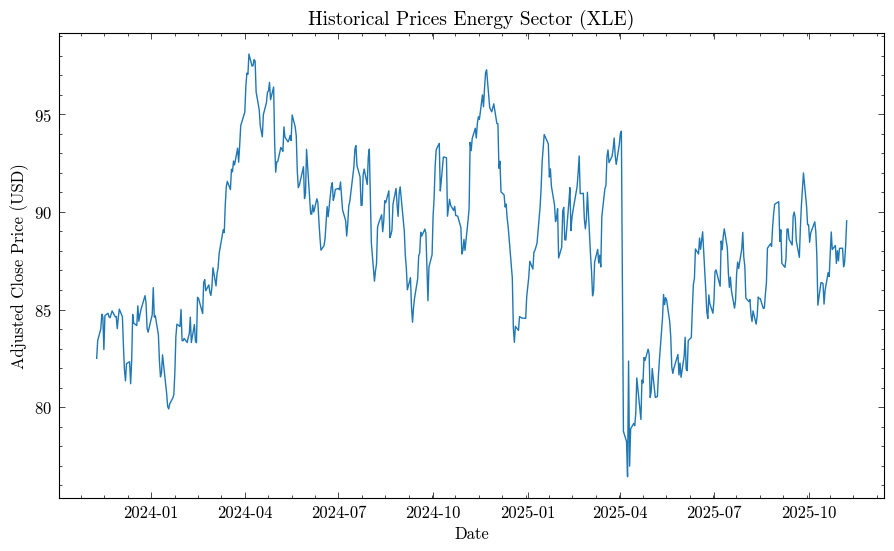

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("white")
ax.plot(wide['date'], wide['XLE'])

ax.set_title('Historical Prices Energy Sector (XLE)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price (USD)')


### Daily Returns and Volatility

In [21]:
wide['pct_r_XLE'] = wide['XLE'].pct_change() 
wide['pct_r_SPY'] = wide['SPY'].pct_change()
wide['log_returns_XLE'] = np.log(wide['XLE']).diff(1)
wide['log_returns_SPY'] = np.log(wide['SPY']).diff(1)

In [22]:
wide

,date,SPY,XLE,pct_r_XLE,pct_r_SPY,log_returns_XLE,log_returns_SPY
0,2023-11-09,433.84,82.50,NaN,NaN,NaN,NaN
1,2023-11-10,440.61,83.41,0.011030,0.015605,0.010970,0.015484
2,2023-11-13,440.19,84.01,0.007193,-0.000953,0.007168,-0.000954
3,2023-11-14,448.73,84.76,0.008928,0.019401,0.008888,0.019215
4,2023-11-15,449.68,84.60,-0.001888,0.002117,-0.001889,0.002115
...,...,...,...,...,...,...,...
496,2025-11-03,683.34,88.14,0.000113,0.001877,0.000113,0.001875
497,2025-11-04,675.24,87.19,-0.010778,-0.011854,-0.010837,-0.011924
498,2025-11-05,677.58,87.42,0.002638,0.003465,0.002634,0.003459
499,2025-11-06,670.31,88.27,0.009723,-0.010729,0.009676,-0.010787


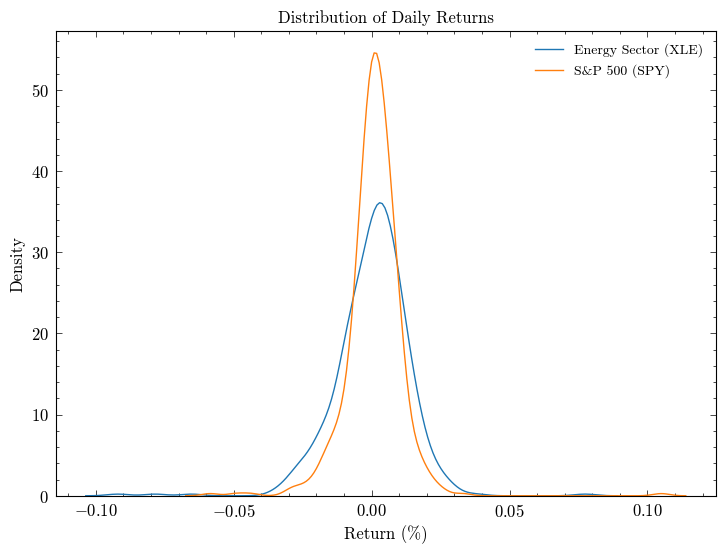

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(wide['pct_r_XLE'], label = 'Energy Sector (XLE)')
sns.kdeplot(wide['pct_r_SPY'], label = 'S&P 500 (SPY)')
plt.title('Distribution of Daily Returns')
plt.xlabel('Return (%)')
plt.legend()

In [24]:
def realized_vol(df, returns, window: int = 21, annualize: bool = True) -> pd.DataFrame:
    """Compute rolling standard deviation of daily returns (realized volatility)."""
    
    vol_df = df[['date']].copy()  # make a DataFrame copy with the date column
    vol_df['volatility'] = df[returns].rolling(window).std()
    
    if annualize:
        vol_df['volatility'] *= np.sqrt(256)
    
    return vol_df

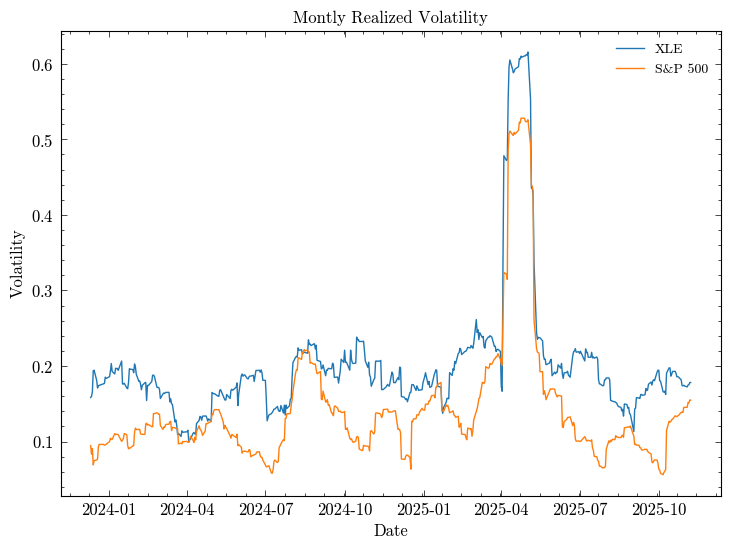

In [25]:
window = 21
XLE_historical_vol = realized_vol(wide, 'log_returns_XLE', window).dropna()
historical_vol = realized_vol(wide, 'log_returns_SPY', window).dropna()


fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Montly Realized Volatility')
ax.plot(XLE_historical_vol['date'], XLE_historical_vol['volatility'], label='XLE')
ax.plot(historical_vol['date'], historical_vol['volatility'], label = 'S&P 500')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
plt.legend()